In [20]:
from flask import Flask, Response, jsonify
from flask_cors import CORS
import cv2
import numpy as np
from keras.models import load_model
from keras.preprocessing.image import img_to_array

In [21]:
app = Flask(__name__)
CORS(app)

In [22]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# Recreate the architecture
def build_model():
    model = Sequential()
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=(48,48,1)))
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(7, activation='softmax'))
    return model

try:
    model = build_model()
    model.load_weights(r"C:\Users\saiteja\OneDrive\Documents\sagar_projects\emotion_recognition\Emotion-Model\emotion_model.h5")
    print("✅ Weights loaded into new model architecture successfully.")
except Exception as e:
    print(f"❌ Failed to load weights: {e}")


✅ Weights loaded into new model architecture successfully.


In [23]:
# Initialize webcam
camera = cv2.VideoCapture(0)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')


In [24]:
def get_emotion_prediction(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

    emotion_data = {label.lower(): 0 for label in emotion_labels}

    for (x, y, w, h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_gray = cv2.resize(roi_gray, (48, 48))
        roi = roi_gray.astype("float") / 255.0
        roi = img_to_array(roi)
        roi = np.expand_dims(roi, axis=0)

        preds = model.predict(roi)[0]
        for i, label in enumerate(emotion_labels):
            emotion_data[label.lower()] = round(float(preds[i]) * 100, 2)
        break  # only process the first face for now

    return emotion_data

In [ ]:
@app.route("/emotion", methods=["GET"])
def emotion_v1():  # different name
    ret, frame = camera.read()
    if not ret:
        return jsonify({"error": "Failed to capture frame"}), 500

    data = get_emotion_prediction(frame)
    return jsonify(data)




AssertionError: View function mapping is overwriting an existing endpoint function: emotion_v1

✅ Model loaded successfully.
Found 7178 images belonging to 7 classes.
Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
225/225 [==============================] - 11s 49ms/step

Confusion Matrix:
 [[ 454    2   39  101  222   99   41]
 [  60    6    9    7    8   16    5]
 [ 152    0  135  103  275  193  166]
 [  35    0   21 1535  113   27   43]
 [  76    0   10  105  904  113   25]
 [ 131    0   37  156  484  412   27]
 [  30    0   29   65   66   12  629]]
✅ Accuracy: 0.5677
✅ Loss (Categorical Crossentropy): 1.1216


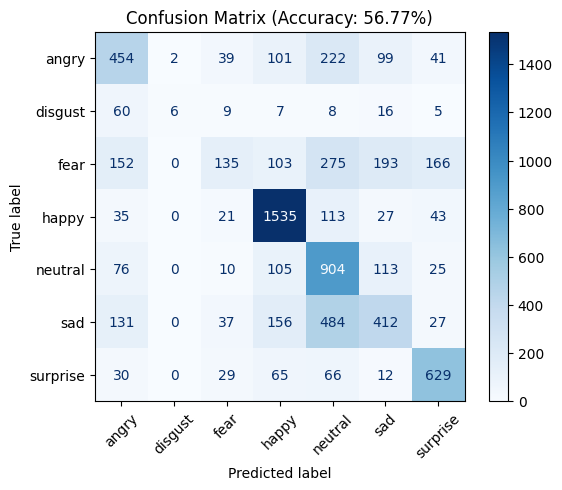

In [10]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, log_loss
import matplotlib.pyplot as plt

# -----------------------------
# 1. Load Model
# -----------------------------
model = load_model(r"C:\Users\kotaa\Downloads\emotion_recognition_1\emotion_recognition\cnn_emotion_model.h5")
print("✅ Model loaded successfully.")

# -----------------------------
# 2. Load Test Data
# -----------------------------
test_dir = r"C:\Users\kotaa\Downloads\emotion_recognition_1\emotion_recognition\data\test"

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    color_mode='grayscale',  # use 'rgb' if your model expects color
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Class labels
class_labels = list(test_generator.class_indices.keys())
print("Classes:", class_labels)

# -----------------------------
# 3. Predictions
# -----------------------------
y_prob = model.predict(test_generator)  # probabilities
y_pred = np.argmax(y_prob, axis=1)  # predicted class indexes
y_true = test_generator.classes  # true class indexes

# -----------------------------
# 4. Confusion Matrix & Accuracy
# -----------------------------
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", cm)

accuracy = cm.trace() / cm.sum()
print(f"✅ Accuracy: {accuracy:.4f}")

loss = log_loss(y_true, y_prob)
print(f"✅ Loss (Categorical Crossentropy): {loss:.4f}")

# -----------------------------
# 5. Plot Confusion Matrix
# -----------------------------
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title(f"Confusion Matrix (Accuracy: {accuracy:.2%})")
plt.show()
